# Player activity on PLAIcraft and its effects on newsletter subscription 
# DSCI 100 section 6 group 16 Project
## members:
|Name|Student Number|
|--------|---------|
|Clement Cheung|40162752|
|Eileen Limneus|81033300|
|Min Hyung Yoo|26944660|
|Tyler Lee|12253688|

### Introduction
This project analyzes two datasets, `sessions.csv` and `players.csv`, containing player activity data from the PLAICraft Minecraft server. The data was collected by a research group in Computer Science at UBC to study how people engage with video games. 
+ **Broad Question:** (1) What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

+ **Specific Question:** How does a player's tendency to revisit the PLAICraft server, and their total playtime affect their subscription status to a game-related newsletter?

To answer our research question, we use information from both `players.csv` and `sessions.csv`: 
1. The raw data set `sessions.csv` is a data set that contains a list of individual play sessions by each player, including data about the session. This dataset contains 1535 rows x 5 columns:
<ul>

|Variable|Data type|
|--------|---------|
|Hashed email|character|
|Start time|character|
|End time|character|
|Original start time|double|
|Original end time|double|

</ul>
The start time and end time are both written in untidy format. More specifically, data for these variables are written in the "original time" format.

(**original time** is the number of milliseconds since January 1, 1970, 00:00:00 UTC.)<br><br> 

2. The raw data set `players.csv` contains a list of all unique players, including demographics and identifying data about each player. This dataset contains 196 rows x 7 columns:
<ul>

|Variable|Data type|
|--------|---------|
|Experience (Beginner, Regular, Amateur, Veteran, Pro)|character|
|Hashed email|character|
|Gender|character|
|Name|character|
|Subscribe (True/False)|logical|
|Played hours|double|
|Age|double|
                                            
</ul>

### Methods & Results

First, we loaded the necessary packages using the `library` function

In [1]:
# loading the 
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(infer)
library(repr)
library(GGally)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### reading the data

We then assign the data sets to objects with human readable names! from `sessions.csv` and `players.csv` to `session_data` and `players_data` respectively.

In [2]:
session_data <- read_csv("sessions.csv")
players_data <- read_csv("players.csv")
session_data
players_data

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


#### processing session_data and merging the two dataframes

Since we wanted to utilise data from both datasets, we needed to modify `sessions_data` in a way that each observation represented a single player, rather than session.

1) We modified `sessions_data` through the use of the`group_by` function, which allowed us to manipulate the data into considering the data by each players individual email. 

2) The `summarize` function allowed us to create a new tibble based on a separate column counting of how many times the same email was recorded in the dataset - done by the `count = ()` function.

3) Finally, the `arrange` was used with `-count` specified so as to order the dataset in a descending order based on the number of instances each email had.


In [3]:
session_data <- session_data |> 
group_by(hashedEmail) |>
summarise(count = n()) |>
arrange(-count)
session_data

hashedEmail,count
<chr>,<int>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159
⋮,⋮
fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,1
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1


We followed up this step with `full_join` to combine both datasets into a single tibble, using `hashedEmail` as the junction.

In [4]:
final_data <- full_join(session_data, players_data, by = "hashedEmail")
final_data

hashedEmail,count,experience,subscribe,played_hours,name,gender,Age
<chr>,<int>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310,Amateur,TRUE,56.1,Dana,Male,23
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219,Regular,TRUE,223.1,Hiroshi,Male,17
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159,Amateur,TRUE,150.0,Delara,Female,16
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
514ebbaa30f0d162127e065ab780892b7930cf8d75944d5eb09c91c02d6026c7,NA,Amateur,FALSE,0,Orion,Male,17
644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,NA,Amateur,TRUE,0,Rhys,Male,20
b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,NA,Amateur,TRUE,0,Bailey,Female,17


# Section 1: Basic analysis and identifying trends for a predictive model

We begin by plotting our data. 

After making the graph a reasonable size using the `options` function, we used `ggplot` with `final_data` dataset to plot the data.

We set the x-axis to the data from the `count` column and set the y-axis to the data from the `played_hours` column, we also colour labelled the data points by `subscribe` to denote subscription status.

We made it a scatterplot through `geom_point()`. The x-axis was labelled `“Number of occurrences to the server”`, while the y-axis was labelled `“Play Time in hours”`. The color classification was labeled `“subscription status”`. (see figure 1)

We also created two histograms `hours_dist` and `occurence_dist` to identify any possible biases we would need to address later on. (see figures 2)


Warning message:
“Removed 71 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 71 rows containing non-finite outside the scale range (`stat_bin()`).”


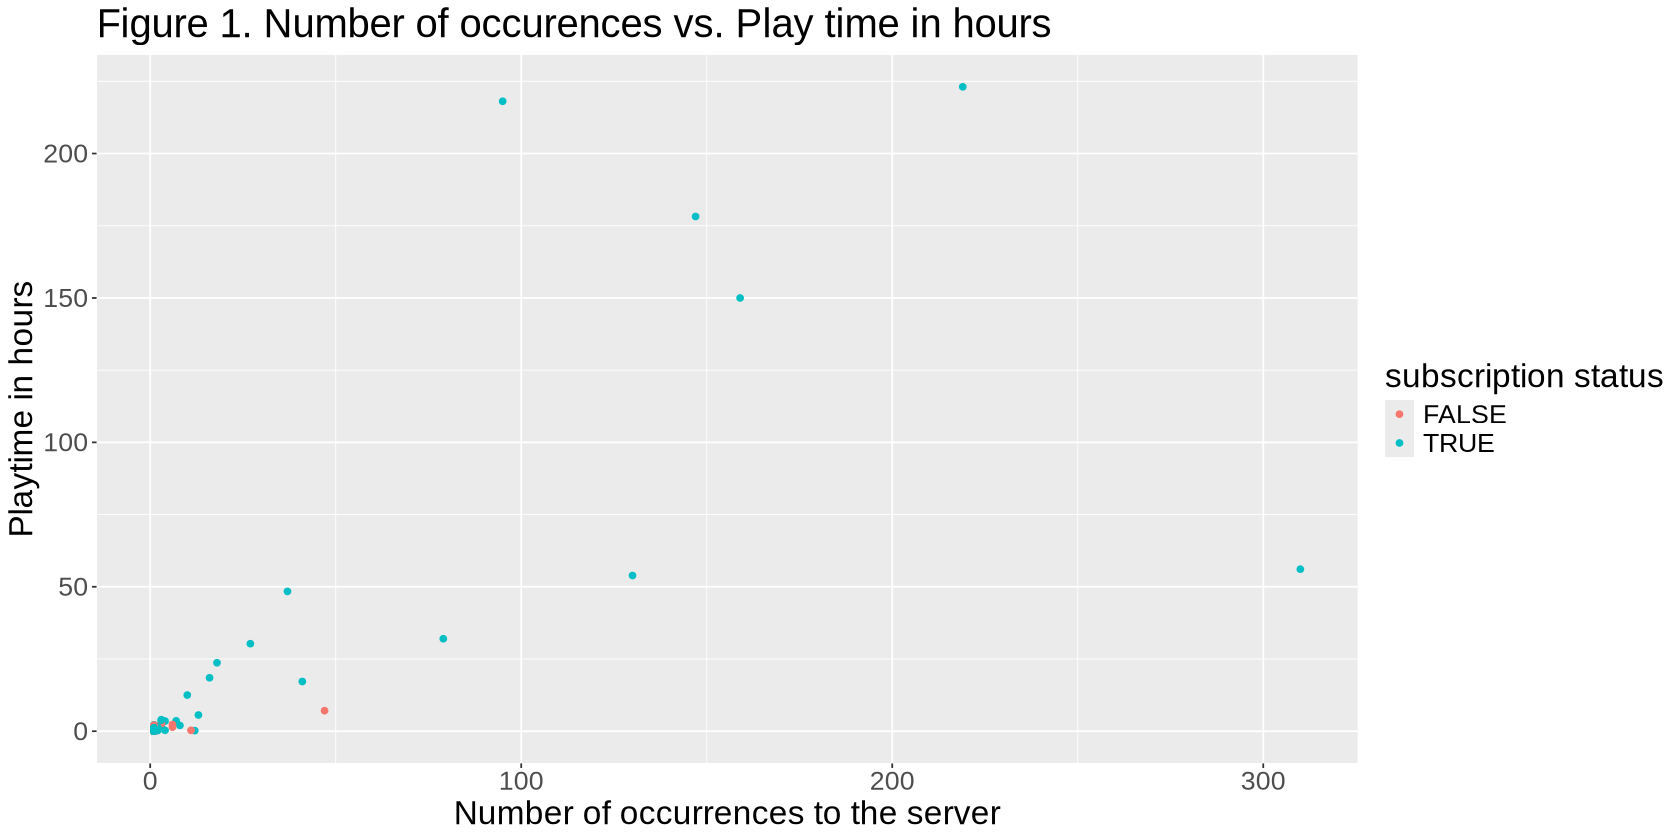

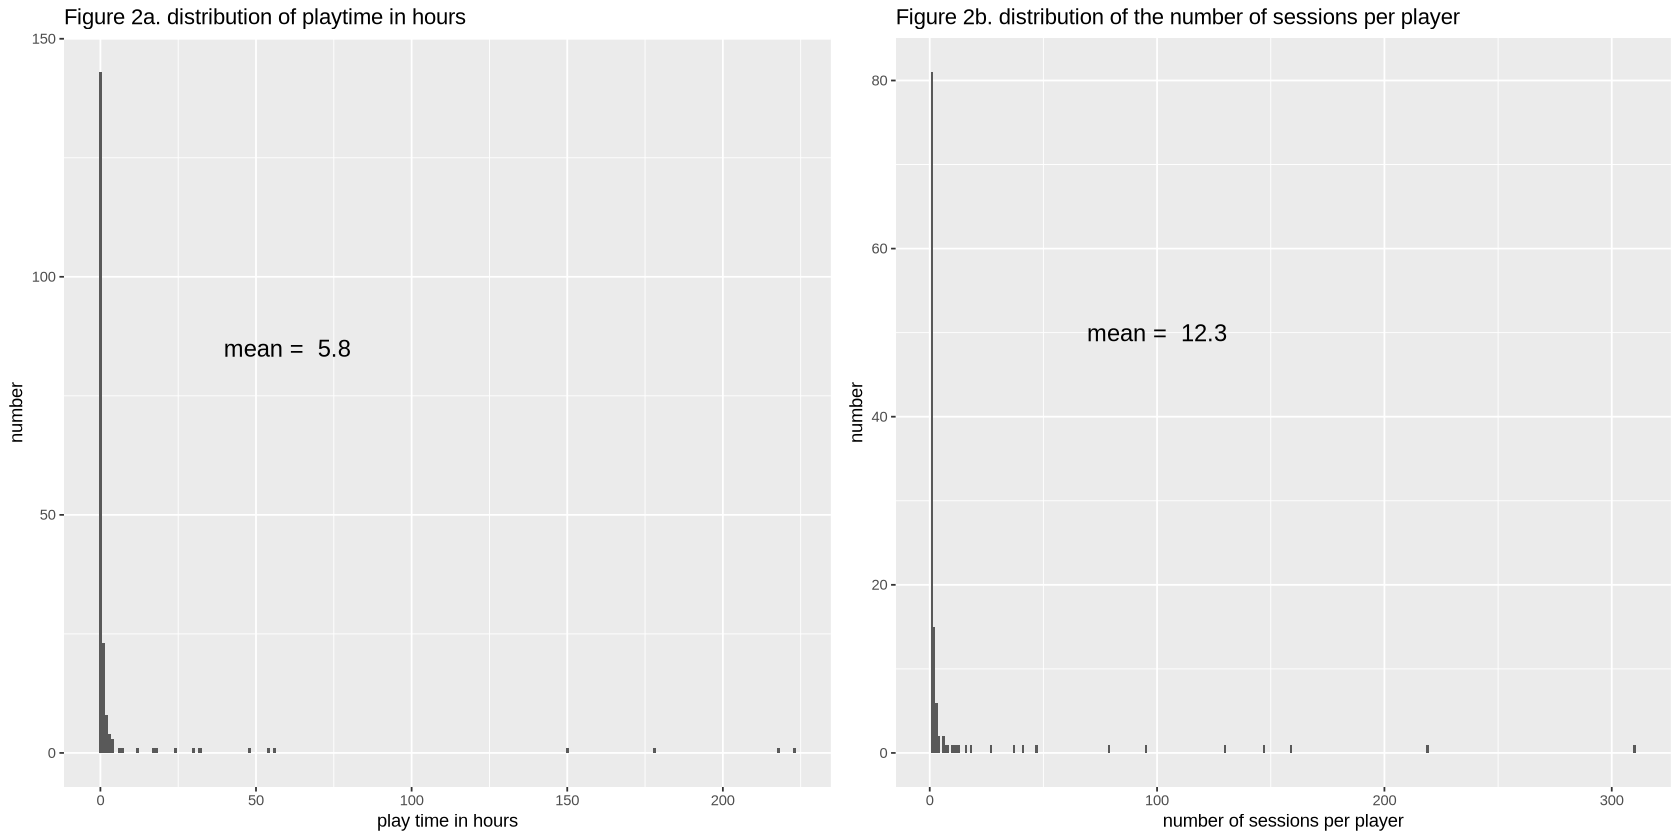

In [5]:
options(repr.plot.width = 14, repr.plot.height = 7)

intial_plot <- final_data |>
    ggplot(aes(x = count, y = played_hours, color = subscribe)) + 
    geom_point() + 
    ggtitle("Figure 1. Number of occurences vs. Play time in hours") +
    labs(x = "Number of occurrences to the server", y = "Playtime in hours", color = "subscription status") +
    theme(text = element_text(size = 20))
intial_plot

hours_dist <- ggplot(final_data, aes(x = played_hours)) +
    geom_histogram(binwidth = 1) +
    ggtitle("Figure 2a. distribution of playtime in hours") +
    labs( x = "play time in hours", y = "number") +
    annotate("text", x = 60, y = 85, label = paste("mean = ", round(mean(final_data$played_hours), 1)), cex = 5)
occurence_dist <- ggplot(final_data, aes(x = count)) +
    geom_histogram(binwidth = 1) +
    ggtitle("Figure 2b. distribution of the number of sessions per player") +
    labs(x = "number of sessions per player", y = "number") +
    annotate("text", x = 100, y = 50, label = paste("mean = ", round(mean(final_data$count, na.rm = TRUE), 1)), cex = 5) 
plot_grid(hours_dist, occurence_dist)

#### At this point...
Given the plot above, it's difficult to draw any conclusions on trends and patterns due to the various outliers skewing distribution. Performing a **95% confidence interval** allows us to dismiss outliers and hone in on a clearer range.

Next, a new dataset named `subscription_class_data` is created from an existing one called `final_data`. This dataset is streamlined to include only the necessary variables for analysis: `played_hours`, `count` (representing how many times a player logged into the server), and `subscribe`.

1) The subscribe column is converted into a categorical factor variable called `subscription_status` using the `mutate` function.
   
2) After preparing the subset, the code applies **normalization** to the two numeric predictor variables: `played_hours` and `count`. (This is done using the `recipes` package, which allows for structured preprocessing of data.)
  
3) The normalization process involves **scaling** and **centering** the variable. This step is necessary due to its accomadation of different units or scales between variables, ensuring each variable contributes 'equally'. The normalisation is also helpful for identifying patterns by making the data easier to visually compare. The preprocessed data is then stored in a new dataset called `normalised_data`.

4) Finally, a scatterplot is created using the `normalised_data`. Despite the normalization, the plot may still appear skewed or **influenced by outliers**, which is why we're planning to follow up with confidence interval analysis to better understand the variability and patterns in our data.


Warning message:
“Removed 71 rows containing missing values or values outside the scale range
(`geom_point()`).”


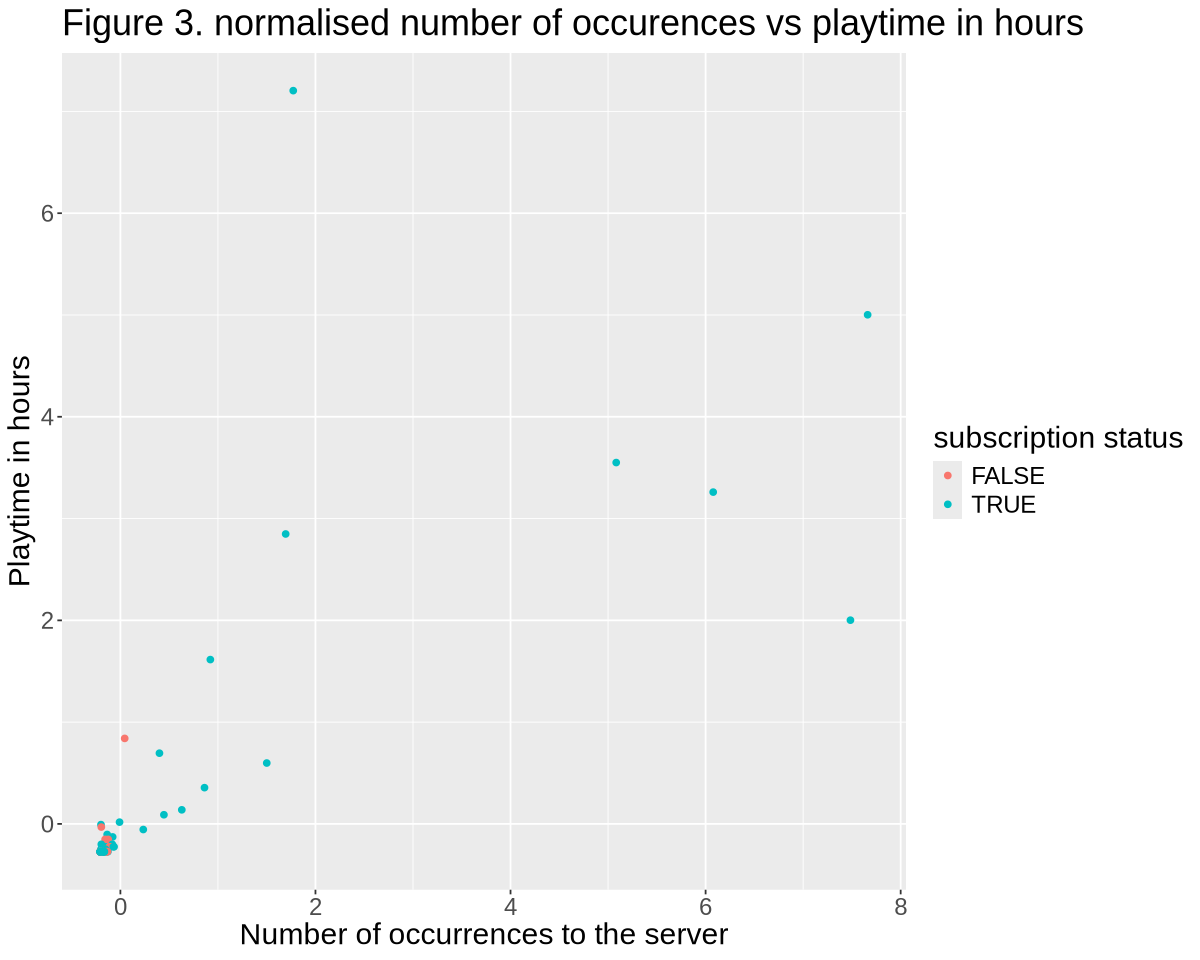

In [6]:
options(repr.plot.width = 10, repr.plot.height = 8)

subscription_class_data <- final_data |>
    mutate(subscription_status = as_factor(subscribe)) |>
    select(subscription_status, played_hours, count)

normalise_recipe <- subscription_class_data |>
    recipe(subscription_status ~ played_hours + count) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()
normalised_data <- bake(normalise_recipe, subscription_class_data)

normalised_plot <- ggplot(normalised_data, aes(x = played_hours, y = count, colour = subscription_status)) +
    geom_point() +
    ggtitle("Figure 3. normalised number of occurences vs playtime in hours") +
    xlab("Number of occurrences to the server") +
    ylab("Playtime in hours") +
    labs(color = "subscription status") +
    theme(text = element_text(size = 18))
normalised_plot

As the data still appeared skewed, with observations in the extreme significantly influencing the resulting plot, we explored confidence intervals to better understand the varaibles and hopefully identify values and ranges we can appropriate limit the variables to.|

We used two approaches: a **t-test** and a **quantile-based** method.

In [7]:
t_test_occurences <- t.test(final_data$count, conf.level = 0.95)
print(t_test_occurences$conf.int)

t_test_hours <- t.test(final_data$played_hours, conf.level = 0.95)

[1]  4.963808 19.596192
attr(,"conf.level")
[1] 0.95


In [8]:
lower_bound_occurences <- quantile(final_data$count, probs = 0.025, na.rm = TRUE)
upper_bound_occurences <- quantile(final_data$count, probs = 0.975, na.rm = TRUE)

lower_bound_hours <- quantile(final_data$played_hours, probs = 0.025, na.rm = TRUE)
upper_bound_hours <- quantile(final_data$played_hours, probs = 0.975, na.rm = TRUE)

First, we applied a **one-sample t-test** to each variable.
The goal here was to calculate a **95% confidence interval** for the **true population mean** of each variable.
+ For count, the interval was approximately `[4.963808, 19.596192]` (Meaning we can be 95% confident that the average number of visits lies within this range.)
+ For 'played_hours', the confidence interval was around `[1.851171, 9.840666]`, (indicating where the true average playtime likely falls.)

To complement this, we also calculated the **2.5th and 97.5th percentiles** of each variable using the `quantile()` function.
+ This approach looks at the actual spread of all the data and captures the central 95% of the observed values, rather than estimating a mean.
+ For count, this range was `[1.0, 145.3]`
+ For played_hours, it was `[0.000 54.175]`.
These ranges reflect the **raw distribution**, including outliers and skewed data, which explains why they are much wider than the t-test intervals.
While both methods offer valuable insight, we found the t-test results more meaningful for our analysis.


Knowing this, we can make some new code and plots that focuses on the range identified by the **t-test** (figure 4a) and **quartiles** (figure 4b) ranges.

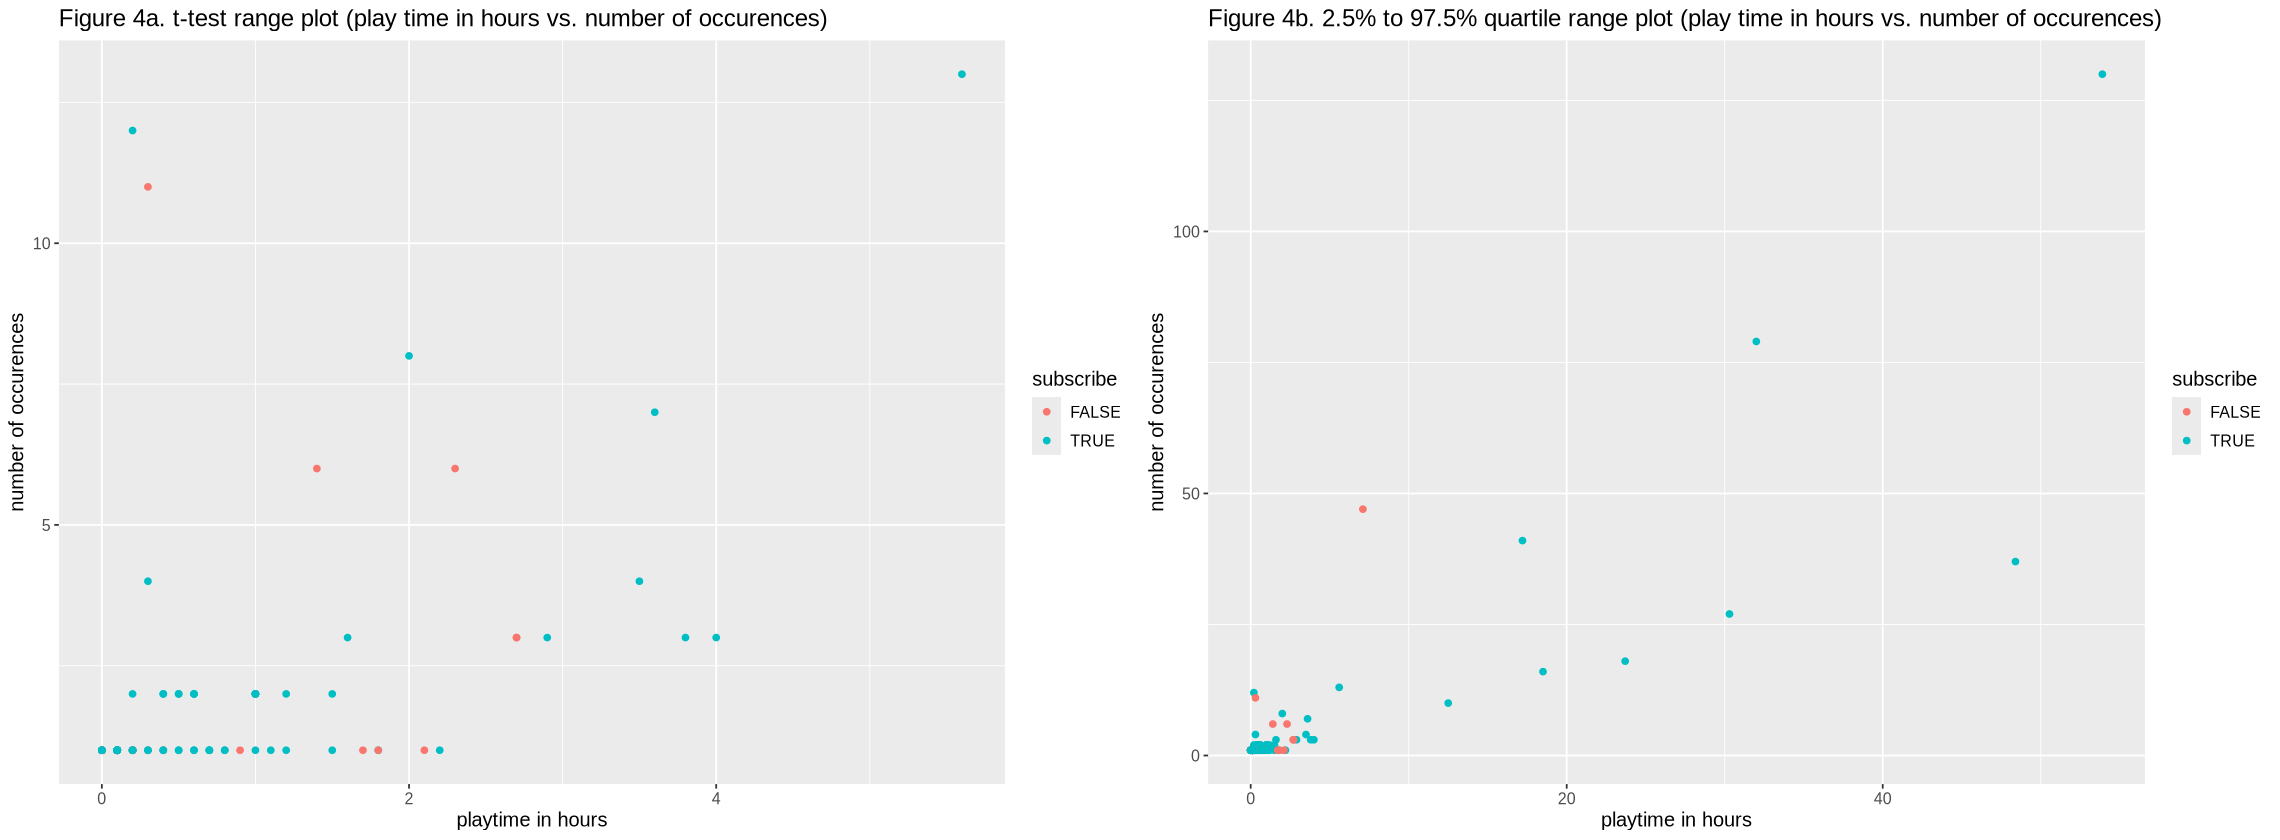

In [23]:
options(repr.plot.width = 19, repr.plot_height = 10)

filtered_quartile_data <- final_data |>
    select(played_hours, count, subscribe) |>
    filter(1.0 <= count & count <= 145.3, 0 <= played_hours & played_hours <= 54.175)

filtered_ttest_data <- final_data |>
    select(played_hours, count, subscribe) |>
    filter(count <= 19.596192, played_hours <= 9.840666)

filtered_data_ttest_plot <- ggplot(filtered_ttest_data, aes(x = played_hours, y = count, colour = subscribe)) +
    geom_point() +
    ggtitle("Figure 4a. t-test range plot (play time in hours vs. number of occurences)") +
    labs(x = "playtime in hours", y = "number of occurences") +
    theme(text = element_text(size = 12))

filtered_quartile_plot <- ggplot(filtered_quartile_data, aes(x = played_hours, y = count, colour = subscribe)) +
    geom_point() + 
    ggtitle("Figure 4b. 2.5% to 97.5% quartile range plot (play time in hours vs. number of occurences)") +
    labs(x = "playtime in hours", y = "number of occurences") +
    theme(text = element_text(size = 12))

plot_grid(filtered_data_ttest_plot, filtered_quartile_plot)

First, we applied a **one-sample t-test** to each variable.
The goal here was to calculate a **95% confidence interval** for the **true population mean** of each variable.
+ For count, the interval was approximately `[4.963808, 19.596192]` (Meaning we can be 95% confident that the average number of visits lies within this range.)
+ For 'played_hours', the confidence interval was around `[1.851171, 9.840666]`, (indicating where the true average playtime likely falls.)

To complement this, we also calculated the **2.5th and 97.5th percentiles** of each variable using the `quantile()` function.
+ This approach looks at the actual spread of all the data and captures the central 95% of the observed values, rather than estimating a mean.
+ For count, this range was `[1.0, 145.3]`
+ For played_hours, it was `[0.000 54.175]`.
These ranges reflect the **raw distribution**, including outliers and skewed data, which explains why they are much wider than the t-test intervals.
While both methods offer valuable insight, we found the t-test results more meaningful for our analysis.

The data was then filtered based on the range identified by the results of a t-test. The goal was to narrow down the dataset to players whose `played_hours` and `count` of visits fall within specific boundaries. A **scatter plot** (figure 5) was then created to visualize the relationship between 'played_hours' and 'count'. 


After observing the above scatter plot (figure 4a & b), it was noted that many of the data points represented players who only visited the platform once, contributing **noise** in the visualization, 

So, new filter was applied to create a subset of the data that **only included recurring players**. A new scatter plot was generated for this filtered data, showing the relationship between 'played_hours' and 'count' for recurring players only. This filtering helped to clean up the plot, although it significantly reduced the sample size from **196 players to just 44**.

This observation led to the suggestion of a **new potential direction** for analysis: exploring the **proportion** of subscribers among **recurring players versus one-time** visitors.

played_hours,count,subscribe
<dbl>,<int>,<lgl>
56.1,310,TRUE
223.1,219,TRUE
150.0,159,TRUE
⋮,⋮,⋮
0.6,2,TRUE
0.6,2,TRUE
1.0,2,TRUE


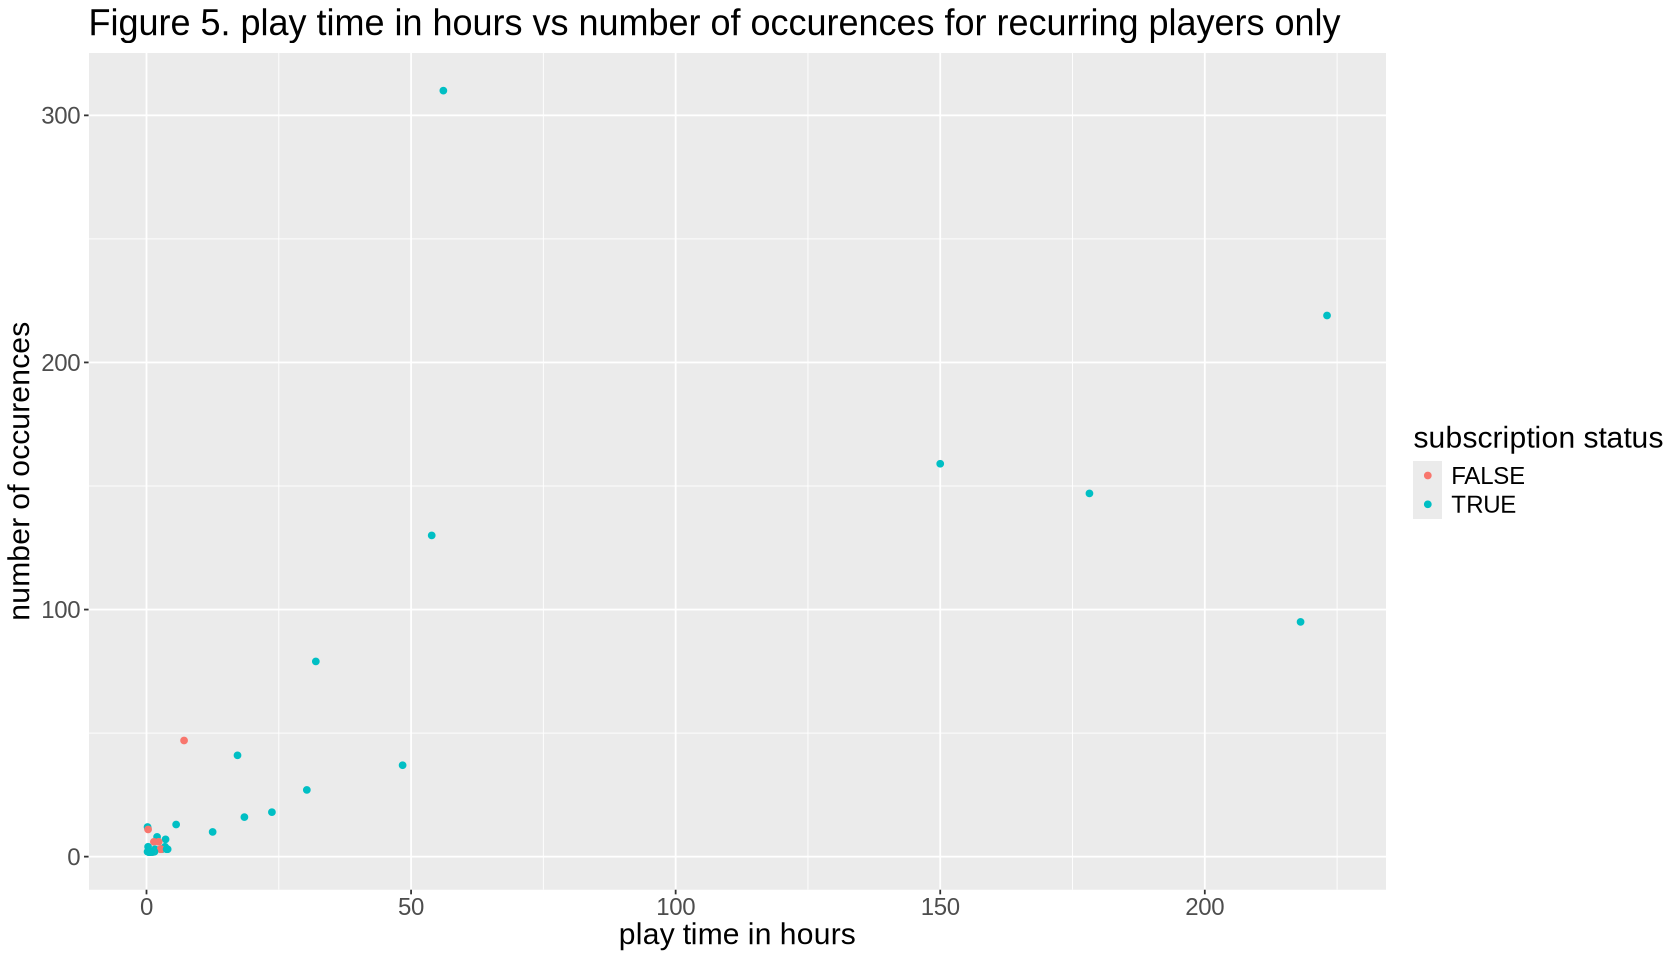

In [10]:
options(repr.plot.width = 14)

filtered_recurring_only <- final_data |>
    select(played_hours, count, subscribe) |>
    filter(count > 1)
filtered_recurring_only
recurring_plot <- ggplot(filtered_recurring_only, aes(x = played_hours, y = count, colour = subscribe)) +
    geom_point() +
    ggtitle("Figure 5. play time in hours vs number of occurences for recurring players only") +
    labs(x = "play time in hours", y = "number of occurences", color = "subscription status") +
    theme(text = element_text(size = 18))
recurring_plot


We do this by creating two new columns:

+ identifying `one-time players` and another
+ identifying `recurring players`

using the `pivot_longer` function. Any players with missing data for `count` were excluded. A **bar graph** (figure 6) was then generated to show the distribution of subscribers and non-subscribers within both player types.


hashedEmail,count,experience,subscribe,played_hours,name,gender,Age,player_type,player_type_truth
<chr>,<int>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310,Amateur,TRUE,56.1,Dana,Male,23,recurring,TRUE
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219,Regular,TRUE,223.1,Hiroshi,Male,17,recurring,TRUE
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159,Amateur,TRUE,150.0,Delara,Female,16,recurring,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,1,Pro,TRUE,1.2,Sakura,Male,17,onetime,TRUE
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1,Amateur,TRUE,0.1,Fatima,Male,17,onetime,TRUE
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1,Beginner,TRUE,1.1,Caden,Male,20,onetime,TRUE


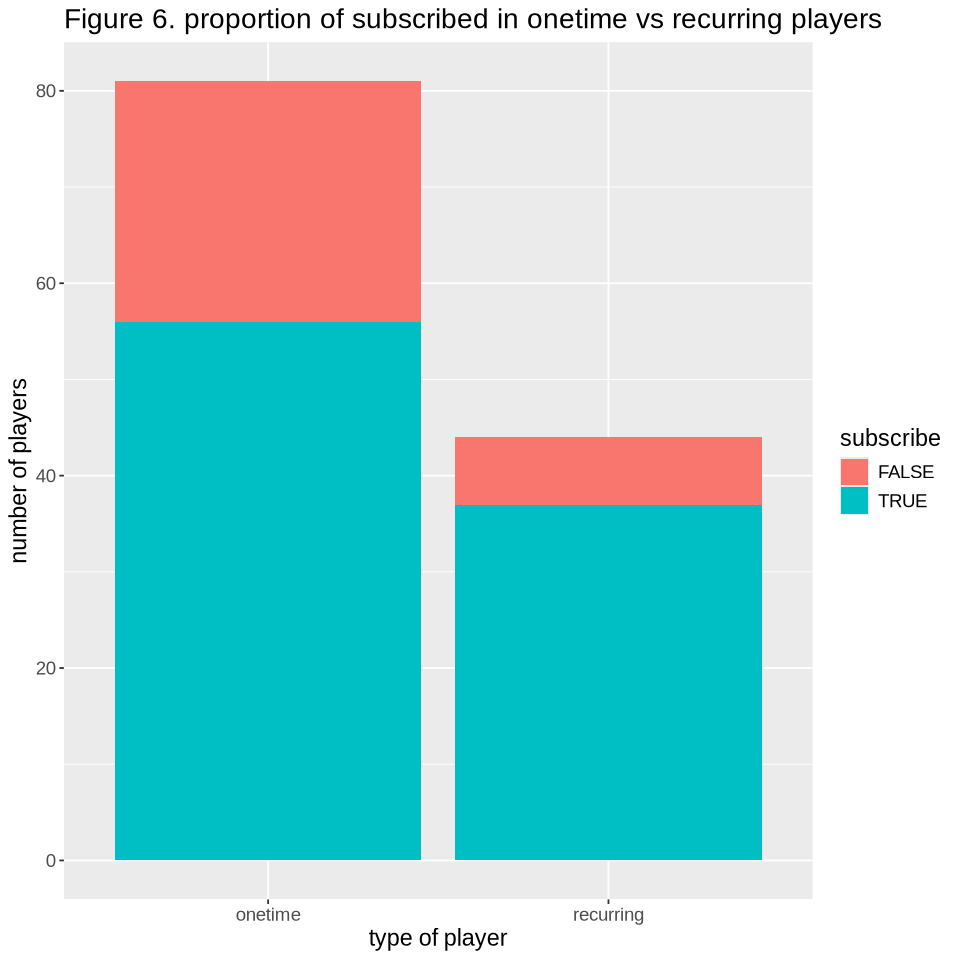

In [11]:
options(repr.plot.width = 8, repr.plot_height = 8)

onetime_vs_recurring_data <- final_data |>
    mutate(onetime = count == 1, recurring = count > 1) |>
    pivot_longer(cols = onetime:recurring, names_to = "player_type", values_to = "player_type_truth") |>
    group_by(player_type_truth) |> 
    filter(player_type_truth == "TRUE")
onetime_vs_recurring_data

# the above code makes a new column showing whether a player is recurring or a onetime player.
# the code also removed 71 players. These were individuals with NA as their count, and were therefore unable to be classified as recurring or onetime.

onetime_vs_recurring_plot <- ggplot(onetime_vs_recurring_data, aes(x = player_type, fill = subscribe)) +
    geom_bar(stat = "count") +
    labs(x = "type of player", y = "number of players", color = "subscription status") +
    ggtitle("Figure 6. proportion of subscribed in onetime vs recurring players") +
    theme(text = element_text(size = 14))
    
onetime_vs_recurring_plot


The plot showed that recurring players had a higher proportion of subscriptions compared to one-time players, proposing the idea that subscription is more common among users who return to play multiple times. 

# Section 2: Classification

In this part of the analysis, the data was prepared for building a predictive model.

1) The subscribe column was **converted into a factor** since it represents a categorical outcome (subscribed or not).
2) To ensure the model treats all variables fairly, the data was **scaled and centered** using `recipe()`.
3) A **K-Nearest Neighbors** (KNN) classification model was then created to predict subscription status based on `count` and `played_hours`.
4) **Cross-validation** with **5 folds** was used to test different values of k (from 1 to 10) to find the number of neighbors that produced the best accuracy.
5) Finally, a plot was generated to visualize the relationship between the number of neighbors and model accuracy, helping to identify the optimal k value for prediction.

In [12]:
onetime_vs_recurring_data_sub <- onetime_vs_recurring_data |>
mutate(subscribe = as.factor(subscribe))
onetime_vs_recurring_data_sub

hashedEmail,count,experience,subscribe,played_hours,name,gender,Age,player_type,player_type_truth
<chr>,<int>,<chr>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310,Amateur,TRUE,56.1,Dana,Male,23,recurring,TRUE
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219,Regular,TRUE,223.1,Hiroshi,Male,17,recurring,TRUE
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159,Amateur,TRUE,150.0,Delara,Female,16,recurring,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,1,Pro,TRUE,1.2,Sakura,Male,17,onetime,TRUE
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1,Amateur,TRUE,0.1,Fatima,Male,17,onetime,TRUE
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1,Beginner,TRUE,1.1,Caden,Male,20,onetime,TRUE


In [13]:
set.seed(9999) 

data_recipe <- recipe(subscribe ~ count + played_hours, data = onetime_vs_recurring_data_sub) |>
                       step_scale(all_predictors()) |>
                       step_center(all_predictors())

data_scaled <- data_recipe |>  
                           prep() |> 
                           bake(onetime_vs_recurring_data_sub)

data_scaled

count,played_hours,subscribe
<dbl>,<dbl>,<fct>
7.204024,1.336120,TRUE
5.002069,6.090327,TRUE
3.550230,4.009294,TRUE
⋮,⋮,⋮
-0.2729457,-0.2267899,TRUE
-0.2729457,-0.2581050,TRUE
-0.2729457,-0.2296367,TRUE


As you can see above, there are some value that goes to the negative resulting from the scaling, which cannot be happen in real-life. But since this predictive model is just assigning a best fitting character classification based on nearest neighbours, rather than a predicting a value, this is allowable.

$x
[1] "Neighbors"

$y
[1] "Accuracy Estimate"

attr(,"class")
[1] "labels"

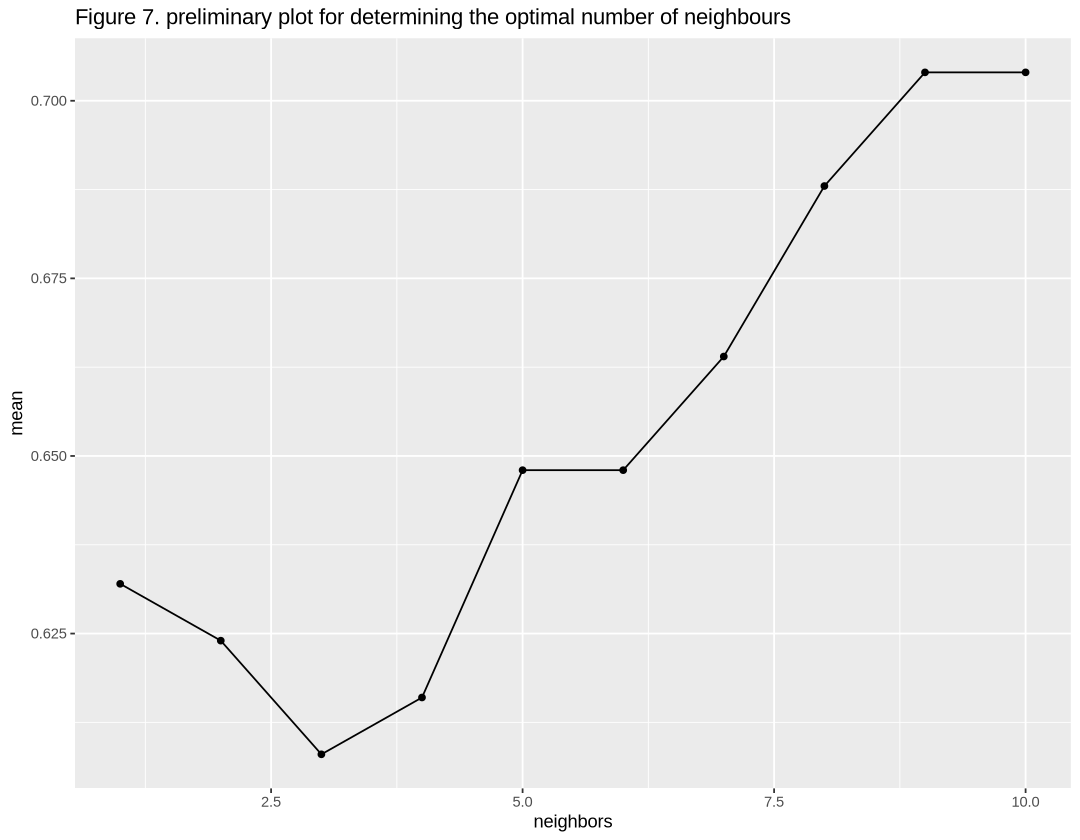

In [14]:
set.seed(9999) 

options(repr.plot.height = 7, repr.plot.width = 9)

data_recipe <- recipe(subscribe ~ count + played_hours, data = onetime_vs_recurring_data_sub) |>
                       step_scale(all_predictors()) |>
                       step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

data_vfold <- vfold_cv(onetime_vs_recurring_data_sub, v = 5, strata = NULL)

k_vals <- tibble(neighbors = c(seq(from = 1, to = 10, by=1)))

knn_results <- workflow() |>
      add_recipe(data_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = data_vfold, grid = k_vals) |>
      collect_metrics()

accuracies <- knn_results |> 
      filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      ggtitle("Figure 7. preliminary plot for determining the optimal number of neighbours") 
      labs(x = "Neighbors", y = "Accuracy Estimate") 


cross_val_plot


This part of the analysis uses **K-means clustering** to explore potential groupings in the data based on `count` and `played_hours`.
1) The data is first **scaled** and **centered** so that both variables contribute equally to the clustering process.
2) The model then tests different numbers of clusters (k values from 1 to 10) to find the most suitable number of groups.
3) The total **within-cluster sum of squares** (`WSSD`) is calculated for each k value, which measures how compact the clusters are.
4) An **"elbow plot"** (figure 8) is created to visualize this relationship.

The optimal k is found to be 2.

num_clusters,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,sse_total,standard,248,1,NA,Preprocessor1_Model01
1,sse_within_total,standard,248,1,NA,Preprocessor1_Model01
2,sse_total,standard,248,1,NA,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,sse_within_total,standard,7.831932,1,NA,Preprocessor1_Model09
10,sse_total,standard,248.000000,1,NA,Preprocessor1_Model10
10,sse_within_total,standard,3.612499,1,NA,Preprocessor1_Model10


num_clusters,total_WSSD
<dbl>,<dbl>
1,248.00000
2,51.85000
3,28.16623
⋮,⋮
8,8.275045
9,7.831932
10,3.612499


NULL

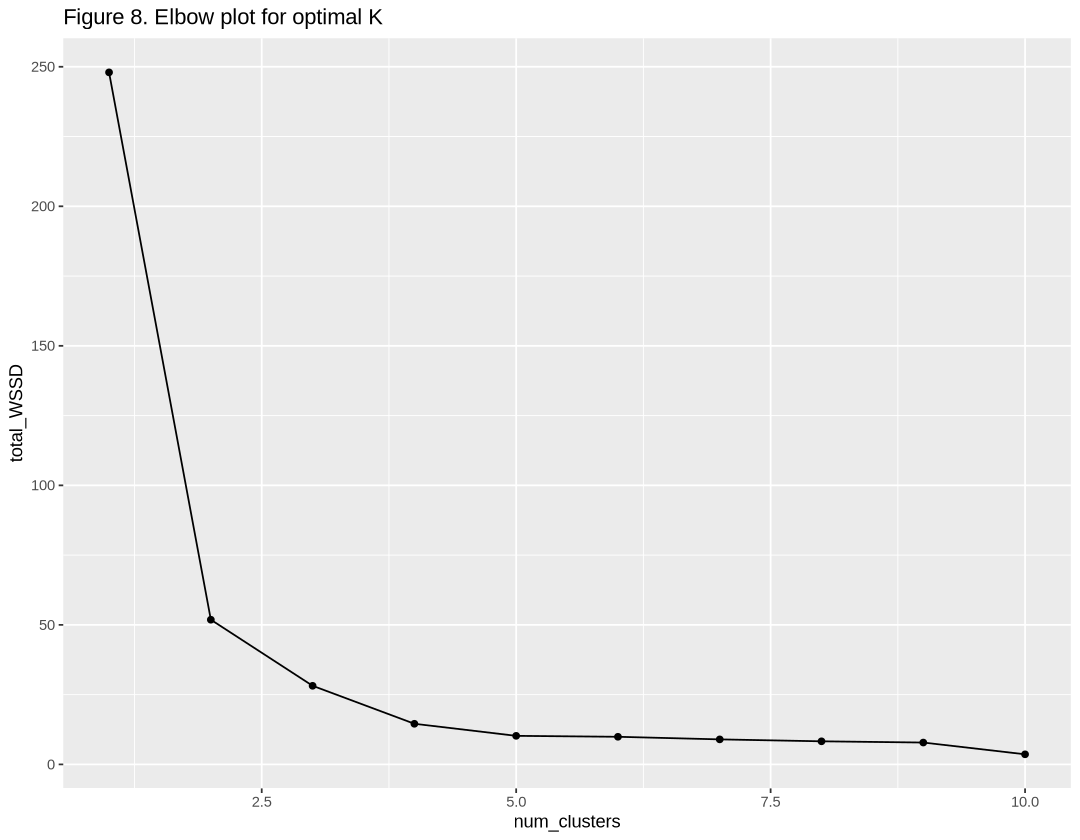

In [15]:
set.seed(9999)

options(repr_lot_width = 11, repr_plot_height = 7)

data_recipe_2 <- recipe( ~ count + played_hours , onetime_vs_recurring_data_sub) |> 
       step_scale(all_predictors()) |> 
       step_center(all_predictors()) 

tib_1 <- tibble(num_clusters = c(seq(from = 1, to = 10, by=1)))

spec <- k_means(num_clusters = tune()) |>
       set_engine("stats", nstart = 10)

tune_stats <- workflow() |>
       add_recipe(data_recipe_2) |>
       add_model(spec) |>
       tune_cluster(resamples = apparent(onetime_vs_recurring_data_sub), grid = tib_1) |>
       collect_metrics()
tune_stats
elbow_stats <- tune_stats |>
mutate(total_WSSD = mean) |>
filter(.metric == "sse_within_total") |>
select(num_clusters, total_WSSD)
elbow_stats

elbow_plot <- elbow_stats |>
ggplot(aes(x = num_clusters, y = total_WSSD)) +
geom_point() +
geom_line() +
ggtitle("Figure 8. Elbow plot for optimal K")
labs(x = "K value",
     y = "Total within-cluster sum of squares") +
    theme(text = element_text(size = 14))
elbow_plot

# Classification with Best K

In this section, a KNN classification model with `k = 2` is used to predict whether a new player would be subscribed based on their `played_hours` and `count`.

1) The data is preprocessed through scaling and centering to ensure balanced influence of predictors.
2) The model is then trained on the full dataset
3) A prediction is made for a new user with `2.5 hours played` and `5 visits`. 

In [16]:
data_recipe <- recipe(subscribe ~ count + played_hours, data = onetime_vs_recurring_data_sub) |>
                       step_scale(all_predictors()) |>
                       step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
      set_engine("kknn") |>
      set_mode("classification")

best_fit <- workflow() |>
      add_recipe(data_recipe) |>
      add_model(knn_spec) |>
      fit(data = onetime_vs_recurring_data_sub)


new_user_1 <- tibble(played_hours = 2.5,
                        count = 5)

subs_predicted_1 <- predict(best_fit, new_user_1)

subs_predicted_1


.pred_class
<fct>
FALSE


## Further predictive plots

1) Next, the code begins by generating predictions from the model `best_fit` that was previously trained on the `onetime_vs_recurring_data_sub` dataset.
2) The `predict()` function is used to make predictions based on this data, and the predicted classes (whether a player is subscribed or not) are added to the original dataset with `bind_cols()`.

This results in a new dataset, `data_preds`, which contains the original data along with a new column for the predicted subscription class `.pred_class`.

Next, a scatter plot `sub_predictions` is created to visualize the relationship between the number of `played hours` and `count`, while color-coding the points according to the predicted subscription status `.pred_class`.


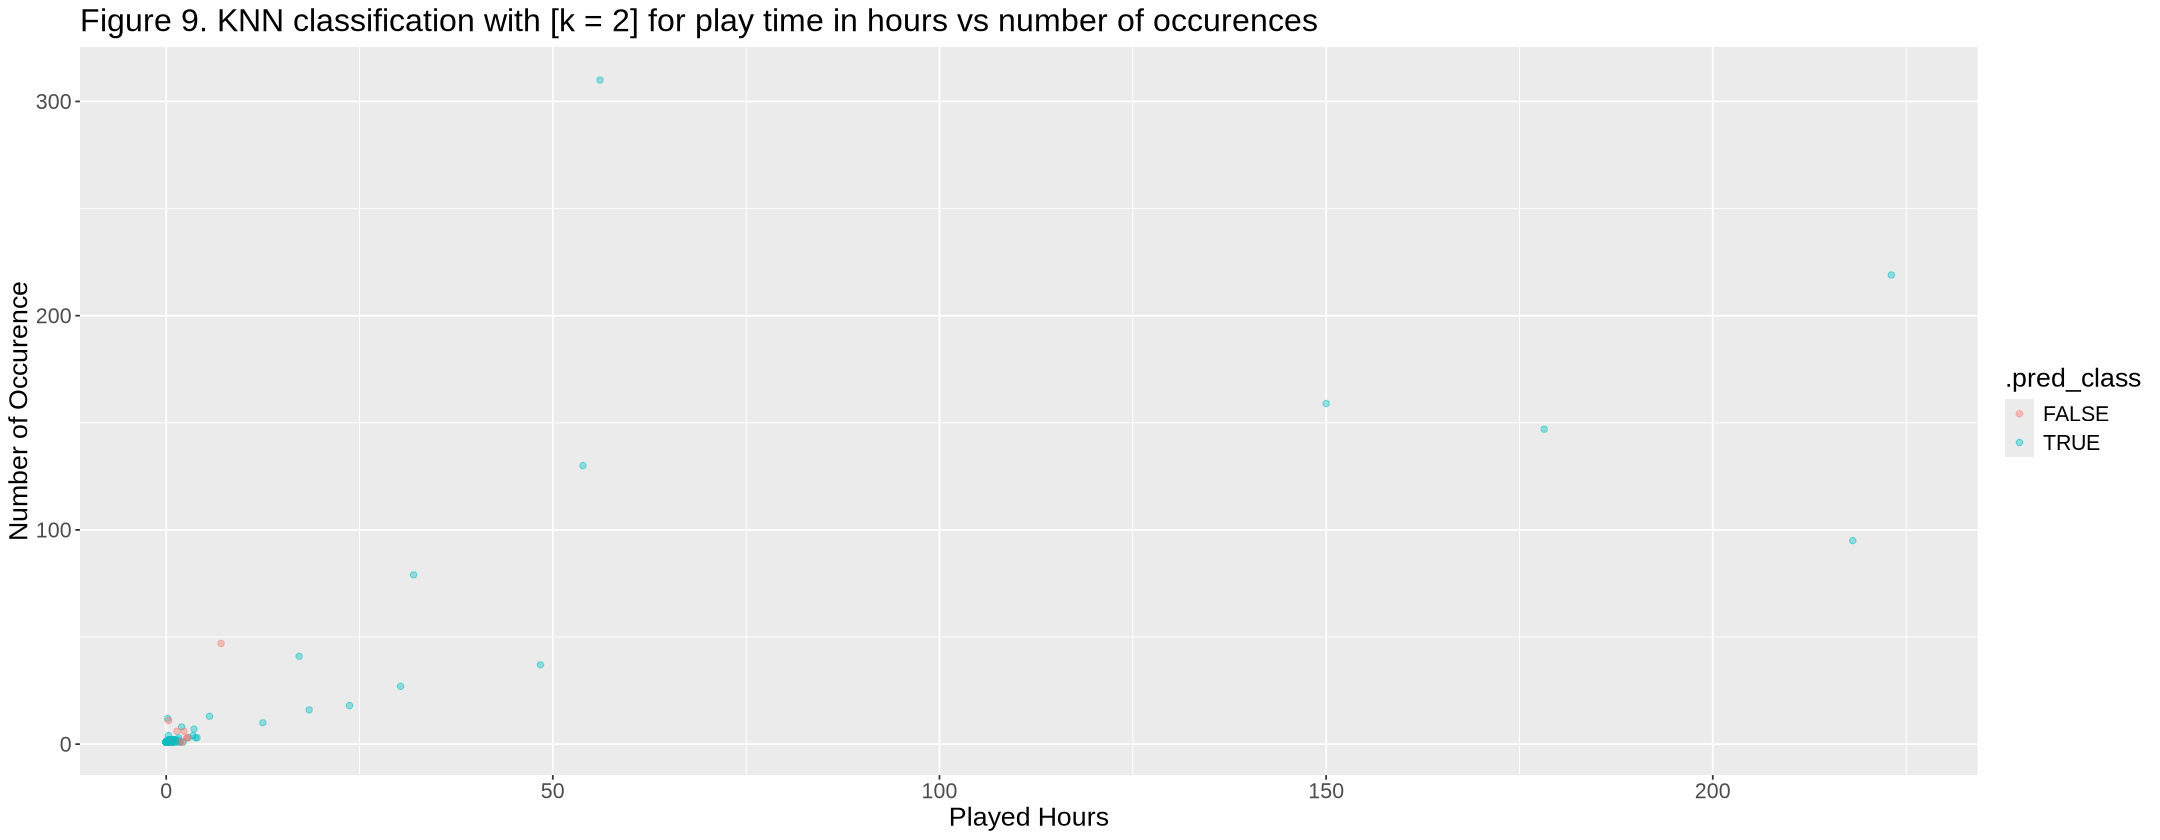

In [17]:
options(repr.plot.width = 18, repr.plot.height = 7)
data_preds <- best_fit |>
  predict(onetime_vs_recurring_data_sub) |>
  bind_cols(onetime_vs_recurring_data_sub)

sub_predictions <- data_preds |>
    ggplot(aes(x = played_hours, y = count, color = .pred_class)) +
        geom_point(alpha = 0.4) +
        xlab("Played Hours") +
        ylab("Number of Occurence") +
    ggtitle("Figure 9. KNN classification with [k = 2] for play time in hours vs number of occurences") +
    theme(text = element_text(size = 16))
sub_predictions

## Plot with X,Y Lim

After that, a second plot `sub_predictions_lim` is created, similar to the first one but with zoomed-in axes.

+ The x-axis is limited to a range from `0 to 5 play hours`
+ the y-axis is limited to a range from `0 to 15 occurrences`.

This zoomed-in version provides a closer look at a specific region of the data where the majority of points seem to lie. The `alpha = 1` ensures that the points are fully opaque, making the plot clearer for this focused area.

Warning message:
“Removed 15 rows containing missing values or values outside the scale range
(`geom_point()`).”


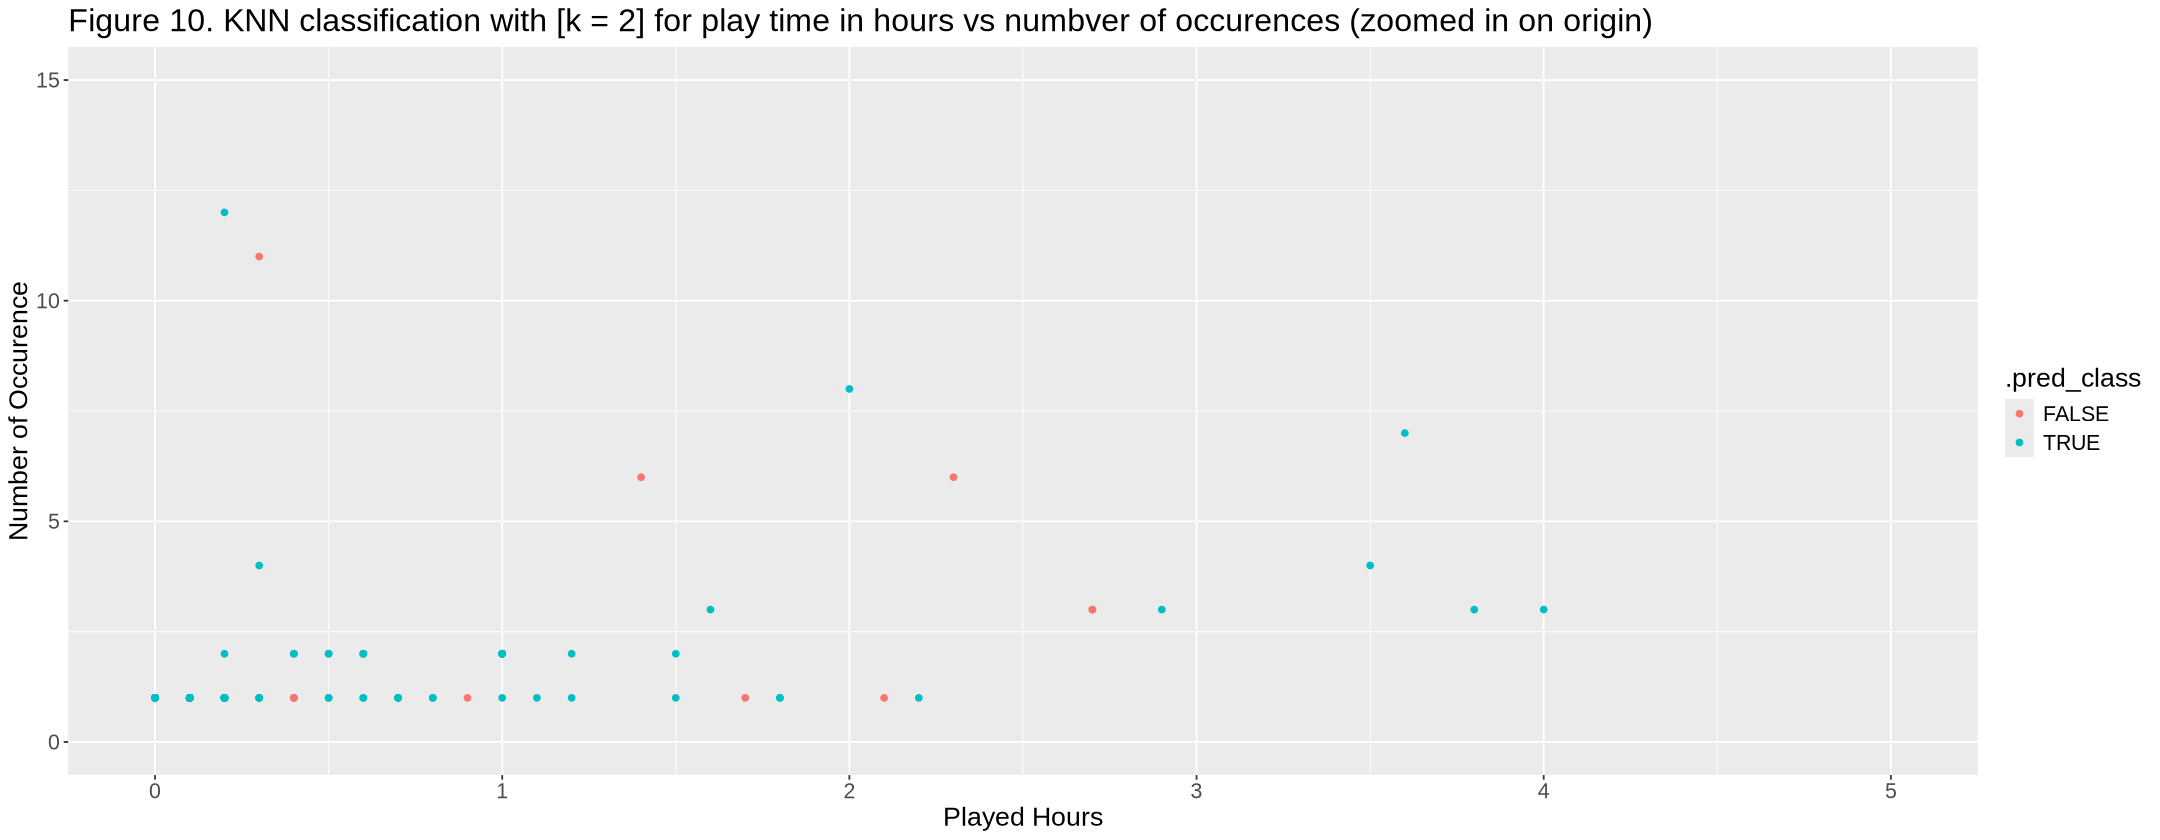

In [18]:
options(repr.plot.width = 18, repr.plot.height = 7)
sub_predictions_lim <- data_preds |>
    ggplot(aes(x = played_hours, y = count, color = .pred_class)) +
        geom_point(alpha = 1) +
        xlim(0, 5) +
        ylim(0, 15) +
        xlab("Played Hours") +
        ylab("Number of Occurence") +
    ggtitle("Figure 10. KNN classification with [k = 2] for play time in hours vs numbver of occurences (zoomed in on origin)") +
    theme(text = element_text(size = 16))
sub_predictions_lim

So far, it is really hard to find a trend on plot, maybe the coding was wrongly processed, or the original data set is just too biased that most of players are already subscribed. 

## Recall the original data set

In this part of the code, the final_data dataset is being split into two subsets based on the subscribe column, which indicates whether a player is subscribed `TRUE` or not `FALSE`.

The `final_data_false` dataset contains only the players who are not subscribed, filtered by `subscribe == FALSE`. Similarly, the `final_data_true` dataset contains only the subscribed players, filtered by `subscribe == TRUE`.

In [19]:
final_data_false <- final_data |>
filter(subscribe == FALSE)
final_data_true <- final_data |>
filter(subscribe == TRUE)

final_data_true
final_data_false

hashedEmail,count,experience,subscribe,played_hours,name,gender,Age
<chr>,<int>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310,Amateur,TRUE,56.1,Dana,Male,23
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219,Regular,TRUE,223.1,Hiroshi,Male,17
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159,Amateur,TRUE,150.0,Delara,Female,16
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
8c9d043ebb3689e679a37bfed30ea96272bcd14689ed2d9fcd68a4ae0c1663bc,NA,Beginner,TRUE,0,Lina,Female,17
644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,NA,Amateur,TRUE,0,Rhys,Male,20
b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,NA,Amateur,TRUE,0,Bailey,Female,17


hashedEmail,count,experience,subscribe,played_hours,name,gender,Age
<chr>,<int>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>
e74c60a92c0100e7240be56d66969db85856152b048c639331a3595f901461ae,47,Beginner,FALSE,7.1,Arash,Male,17
42eafe96ed5c1684e3b5cc614d1b01a117173d3ec6898abcf1177d9822bd39f7,11,Beginner,FALSE,0.3,Ariana,Female,17
88247d9a46fc214a12485dcbcbb03a8ddebfe8c1ec5fe209cd660147625c8e62,6,Veteran,FALSE,1.4,Aiden,Prefer not to say,25
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
f174555ae3ff613d5d0b98f83f26f689619d92ef272f28f3aa236003d3dbb159,NA,Veteran,FALSE,0,Finley,Non-binary,17
e1e5b1d36ab7680b6927fd3cb619c2b5373167750f90f7a21bf67b5d9b0fd73f,NA,Pro,FALSE,0,Jesse,Non-binary,17
514ebbaa30f0d162127e065ab780892b7930cf8d75944d5eb09c91c02d6026c7,NA,Amateur,FALSE,0,Orion,Male,17


Upon inspecting the datasets, we observe the following:

+ of the 196 players in the original dataset, only **52 players are not subscribed** (which accounts for just 26.5% of the total players)
+ The remaining 73.5% of the players are subscribed
  
This imbalance in the data could introduce bias into the classification model, as the model will be trained on a much larger proportion of subscribed players. This imbalance means that the model might be more likely to predict that a player is subscribed, as that is the dominant class in the data. 

## Discussion

Through our analysis, it was found that in a sample group of **196 players**, we found that only 52 were not subscribed to the newsletter.
+ This translated into 73.5% of players in the sample being subscribed, while 26.5% of players were not
This suggests that the proportion of recurring players who had a subscription was significantly higher than that of one-time players. However, it’s also important to note that when plotting the predictive dataset scatterplot, a general trend was difficult to find, suggesting that there may have been an **inherent bias** within the knn-classification model. Furthermore, throughout the data processing there mere a multitude of steps that involved reducing the size of the dataset, possibly decreasing the statistical reliability of the conclusions we made.

Overall, the results that we expected to find was that recurring players were far more likely to subscribe to the newsletter than one-time players, as demonstrated by the histogram. What was not expected was that of the one-time players, the vast majority were still subscribed to the newsletter, albeit at a slightly lower proportion than to that of the recurring players. This is further evidence of the aforementioned bias in the dataset (also demonstrated through the lack of an obvious trend in the predictions scatterplot). This opens up the possibility that if the data was already somehow biased at the beginning, it could have affected the optimal clusters alongside our classification model, resulting in the majority of our predicted data points being classified as 'subscribed’. Ultimately, these results did not completely align with our initial expectations of the data, as the rate of subscription for the newsletter was significantly higher than anticipated for one-time players.

Since this predictive analysis determines the demand for additions such as newsletters based on a player’s habits regarding the game, this analysis could act as a means for determining which demographic of players a newsletter should be catered towards. Thus, these findings would demonstrate that newsletters should be focused on prioritizing the interest of the more experienced side of the game’s community. However, such information could be used to further the demand for said newsletter, by incentivizing players to revisit the game more, as the analysis has already proven that there is a positive relationship between the frequency of gameplay and demand for the newsletter. 

Following this conclusion about the relevance of the analysis, further questions to be asked by game companies and developers could be along the lines of ‘how can players be incentivized to revisit their games?’, or ‘how can newsletters remain relevant to more experienced players’, or even ‘how can newsletters become relevant for newer first-time players?’. Such questions are most relevant based on the predictive analysis, and will aim towards the necessary changes needed in both the game and newsletter to improve demand.


## References (APA)

1) Grolemund, H. W. A. G. Grolemund, H. W. and G. (n.d.). R for Data Science. Retrieved from https://r4ds.had.co.nz/data-visualisation.html
2) Tiffany Timbers, T. C. (2024). Retrieved from https://datasciencebook.ca/index.html
3) Fneish, F. (2021). Calculating Confidence Interval in R. Retrieved from https://firasfneish-statistics-r.netlify.app/post/calculating-confidence-interval-in-r/
4) Awan, A. A. (2023). T-tests in R Tutorial: Learn How to Conduct T-Tests. Retrieved from https://www.datacamp.com/tutorial/t-tests-r-tutorial
5) (N.d.). Retrieved from https://cran.r-project.org/web/packages/distributions3/vignettes/one-sample-t-confidence-interval.html#:~:text=If%20you%20want%20to%20verify,was%200.88)%20via%20the%20conf.